# Labeled Faces In The Wild Deep Learning Classification


## Desription

The LFW (Labeled Faces In The Wild) dataset is composed of 5479 clases (different persons) for more than 13000 images.

## Initialization

In [21]:
# IMSIZE = [250, 250, 3]
DATASET_PATH = "../datasets/lfw_funneled"

## Load and split dataset

In [22]:
import tensorflow as tf

batch_size = 32
SEED = 123
w, h, l = 94, 125, 3
IMG_SHAPE = (h, w, l)

train_ds = tf.keras.utils.image_dataset_from_directory(DATASET_PATH,
                                                       validation_split=0.2,
                                                       subset="training",
                                                       seed=SEED,
                                                       image_size=(h, w),
                                                       batch_size=batch_size)
val_ds = tf.keras.utils.image_dataset_from_directory(DATASET_PATH,
                                                     validation_split=0.2,
                                                     subset="validation",
                                                     seed=SEED,
                                                     image_size=(h, w),
                                                     batch_size=batch_size)

class_names = train_ds.class_names
n_classes = len(class_names)

Found 5985 files belonging to 423 classes.
Using 4788 files for training.
Found 5985 files belonging to 423 classes.
Using 1197 files for validation.


## Show images infos

In [23]:
print(class_names)
print(f"Image dimensions: {w}x{h}x{l}")
print(f"Number of classes: {n_classes}")
print(len(train_ds))

['Abdullah_Gul', 'Adrien_Brody', 'Ahmed_Chalabi', 'Ai_Sugiyama', 'Al_Gore', 'Al_Sharpton', 'Alan_Greenspan', 'Alastair_Campbell', 'Albert_Costa', 'Alejandro_Toledo', 'Ali_Naimi', 'Allyson_Felix', 'Alvaro_Uribe', 'Amelia_Vega', 'Amelie_Mauresmo', 'Ana_Guevara', 'Ana_Palacio', 'Andre_Agassi', 'Andy_Roddick', 'Angela_Bassett', 'Angela_Merkel', 'Angelina_Jolie', 'Ann_Veneman', 'Anna_Kournikova', 'Antonio_Banderas', 'Antonio_Palocci', 'Ari_Fleischer', 'Ariel_Sharon', 'Arminio_Fraga', 'Arnold_Schwarzenegger', 'Arnoldo_Aleman', 'Ashanti', 'Atal_Bihari_Vajpayee', 'Ben_Affleck', 'Benazir_Bhutto', 'Benjamin_Netanyahu', 'Bernard_Law', 'Bertie_Ahern', 'Bill_Clinton', 'Bill_Frist', 'Bill_Gates', 'Bill_Graham', 'Bill_McBride', 'Bill_Simon', 'Billy_Crystal', 'Binyamin_Ben-Eliezer', 'Bob_Graham', 'Bob_Hope', 'Bob_Stoops', 'Boris_Becker', 'Brad_Johnson', 'Britney_Spears', 'Bulent_Ecevit', 'Calista_Flockhart', 'Cameron_Diaz', 'Carla_Del_Ponte', 'Carlos_Menem', 'Carlos_Moya', 'Carmen_Electra', 'Carrie-An

## Show images

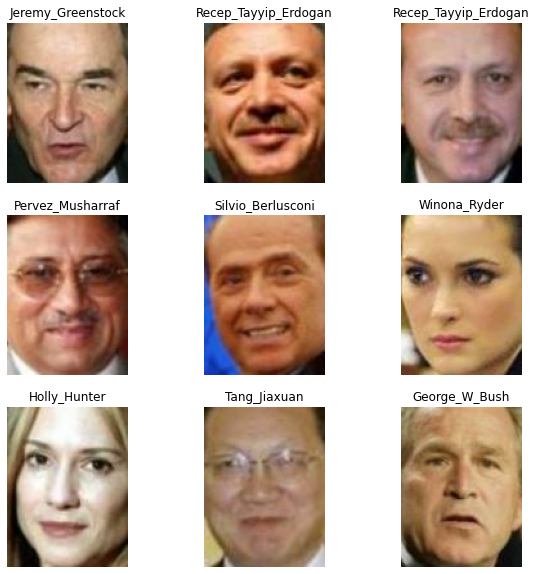

In [24]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [25]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(train_ds))
print('Number of test batches: %d' % tf.data.experimental.cardinality(val_ds))

Number of validation batches: 150
Number of test batches: 38


## Configure dataset performance

In [26]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_ds.prefetch(buffer_size=AUTOTUNE)
validation_dataset = val_ds.prefetch(buffer_size=AUTOTUNE)

## Data augmentation

In [27]:
"""
tf.keras.layers.RandomCrop
tf.keras.layers.RandomFlip
tf.keras.layers.RandomTranslation
tf.keras.layers.RandomRotation
tf.keras.layers.RandomZoom
tf.keras.layers.RandomHeight
tf.keras.layers.RandomWidth
tf.keras.layers.RandomContrast
"""

data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.1),
    # tf.keras.layers.RandomContrast(0.1)
])

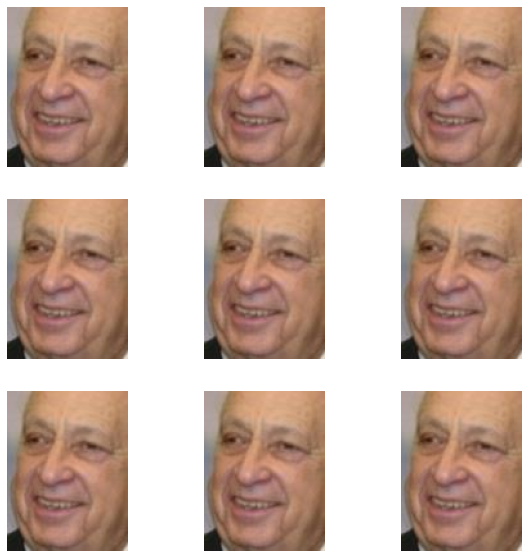

In [28]:
for image, _ in train_dataset.take(1):
    plt.figure(figsize=(10, 10))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0] / 255)
        plt.axis('off')
## Not displaying correctly in Jupyter for unknown reason

## Rescale pixel values

In [29]:
preprocess_input = tf.keras.applications.resnet50.preprocess_input

## Building model


In [ ]:


inputs = keras.Input(shape=input_shape)
x = preprocessing_layer(inputs)
outputs = rest_of_the_model(x)
model = keras.Model(inputs, outputs)

## Training

In [34]:
from keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor="val_accuracy", patience=2)

history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=50,
                    # steps_per_epoch=10587 // batch_size,
                    # validation_steps=2646 // batch_size,
                    callbacks=[early_stop]
                    )

Epoch 1/50
150/150 [==============================] - 68s 406ms/step - loss: 14.1748 - accuracy: 0.1698 - val_loss: 8.8751 - val_accuracy: 0.2807
Epoch 2/50
 61/150 [===========>..................] - ETA: 12s - loss: 4.2499 - accuracy: 0.5272

KeyboardInterrupt: 

## Save model

In [ ]:
model.save_weights("../weights/resnet50_lfw.h5")
